# Region-Adjacency-Graph

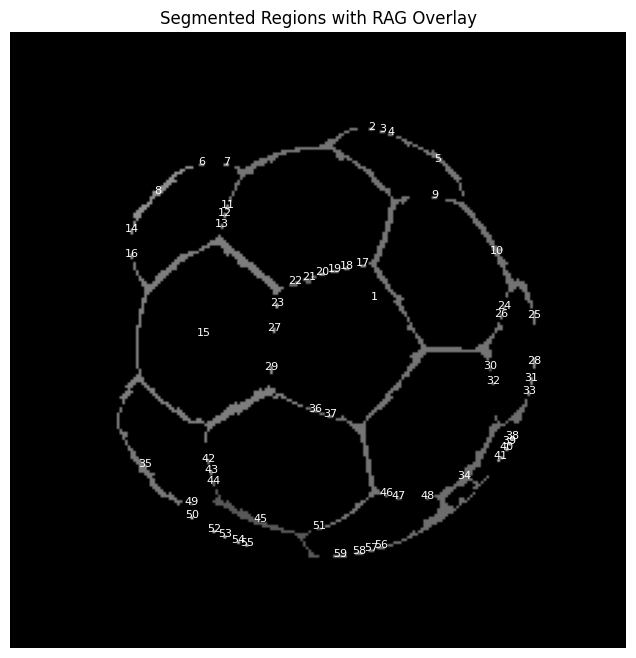

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from skimage.measure import regionprops, label


def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image, gray


def segment_image(gray, image):
    grad = cv2.morphologyEx(gray, cv2.MORPH_GRADIENT, np.ones((3, 3), np.uint8))
    _, binary = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dist_transform = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.4 * dist_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)
    sure_bg = cv2.dilate(binary, np.ones((3, 3), np.uint8), iterations=1)
    unknown = cv2.subtract(sure_bg, sure_fg)
    _, markers = cv2.connectedComponents(sure_fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(image.copy(), markers)
    return markers


def get_region_properties(markers, gray):
    segments = label(markers > 1)
    props = regionprops(segments, intensity_image=gray)
    return segments, props


def build_rag(segments, props, image):
    G = nx.Graph()
    for region in props:
        G.add_node(region.label, centroid=region.centroid, mean_color=np.mean(image[segments == region.label], axis=0))

    for i in range(1, np.max(segments) + 1):
        mask = segments == i
        dilated = cv2.dilate(mask.astype(np.uint8), np.ones((3, 3), np.uint8))
        border = dilated - mask.astype(np.uint8)
        neighbors = np.unique(segments[border.astype(bool)])
        neighbors = [n for n in neighbors if n != i and n > 0]
        for n in neighbors:
            if not G.has_edge(i, n):
                color1 = G.nodes[i]['mean_color']
                color2 = G.nodes[n]['mean_color']
                color_diff = np.linalg.norm(color1 - color2)
                G.add_edge(i, n, weight=color_diff)
    return G


def create_segmented_image(segments, props, G, image_shape):
    segmented_img = np.zeros(image_shape, dtype=np.uint8)
    for region in props:
        mask = segments == region.label
        color = G.nodes[region.label]['mean_color'].astype(np.uint8)
        segmented_img[mask] = color
    return segmented_img


def plot_results(segmented_img, G):
    plt.figure(figsize=(12, 8))
    plt.imshow(segmented_img)
    plt.title("Segmented Regions with RAG Overlay")
    plt.axis('off')

    for node in G.nodes:
        y, x = G.nodes[node]['centroid']
        plt.text(x, y, str(node), color='white', fontsize=8, ha='center')

    for u, v in G.edges:
        y1, x1 = G.nodes[u]['centroid']
        y2, x2 = G.nodes[v]['centroid']
        plt.plot([x1, x2], [y1, y2], 'cyan', linewidth=0.8)

    plt.show()


def main():
    image_path = '../Images/ball.jpg'
    image, gray = load_image(image_path)
    markers = segment_image(gray, image)
    segments, props = get_region_properties(markers, gray)
    G = build_rag(segments, props, image)
    segmented_img = create_segmented_image(segments, props, G, image.shape)
    plot_results(segmented_img, G)


if __name__ == "__main__":
    main()
